Load libraries, define some functions

In [2]:
!pip install ome-zarr

In [3]:
import viz_utils
import pandas as pd

## Creating single cell images

For each of the **215,081** single cell images in the dataset, we can visualize the raw intensities and segmentations for the DNA, membrane, and structure channel using the CFE (Cell Feature Explorer). Segmentations were computed at the FOV level using the Allen Cell and Structure Segmenter (Chen et al., 2018), with code and trained models available at https://github.com/AllenCell/segmenter_model_zoo. Single cells were extracted from the FOVs using the cell segmentation results. All images were rescaled to isotropic voxel sizes by interpolating along the z dimension to upscale the voxel size from 0.108333 $\mu$m x 0.108333 $\mu$m x 0.29 $\mu$m  to 0.108333 $\mu$m x 0.108333 $\mu$m x 0.108333 $\mu$m. ROIs were determined by extending the 3D bounding box of the cell by 40 pixels in x and y, and 10 pixels in z. Initial preprocessing code is available at https://github.com/AllenCell/cvapipe

In [26]:
# Sample a cell
df = pd.read_parquet("s3://variance-dataset/processed/manifest.parquet")
some_cell = df.sample(1).iloc[0]


In [27]:
!pwd

/home/aicsuser/work/cytodata-hackathon-base/notebooks


In [28]:
df = df.iloc[60:200]

In [29]:
df['structure_name'].value_counts()

ACTB      64
TOMM20    54
CETN2     22
Name: structure_name, dtype: int64

In [30]:

viz_utils.DatasetFields.CellImagePath = "max_projection_z"

In [31]:
viz_utils.DatasetFields.CellImagePath

'max_projection_z'

In [33]:
from viz_utils import diagnostic_sheet
diagnostic_sheet(df, max_cells=64, overwrite=True)

/home/aicsuser/work/cytodata-hackathon-base/notebooks/viz_utils.py:350: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  helper_dataset = helper_dataset.append(dataset_subgroup)
/home/aicsuser/work/cytodata-hackathon-base/notebooks/viz_utils.py:350: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  helper_dataset = helper_dataset.append(dataset_subgroup)
/home/aicsuser/work/cytodata-hackathon-base/notebooks/viz_utils.py:350: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  helper_dataset = helper_dataset.append(dataset_subgroup)
/opt/conda/envs/cytodata2/lib/python3.9/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warnin

PosixPath('diagnostic_sheets/manifest.csv')

In [9]:
DatasetFields.CellImagePath

'max_projection_x'

In [ ]:
some_cell['structure_name']

We can visualize the single cell images and their segmentations using the Cell Feature Explorer

In [38]:
# Generate CFE URL
def generate_url(cell_id):
    print(f"Click this link https://allen-cell-animated.github.io/website-3d-cell-viewer/?dataset=aics_hipsc_v2021.1&id={cell_id}")
cell_id = some_cell['CellId'].item() 
generate_url(cell_id)

Click this link https://allen-cell-animated.github.io/website-3d-cell-viewer/?dataset=aics_hipsc_v2021.1&id=742676


Here, we can select *Full Field* at the top middle of the UI to switch to the FOV view.

For the sake of the challenge, single cell images were further preprocessed by merging in the cropped brightfield channel, centering and aligning the image to the longest axis of the membrane segmentation channel, and masking by the membrane segmentation channel. Images were further cropped and resized to a global 3D bounding box by taking the 95% quantile of the individual bounding box widths in x, y, and z. The columns **fits_z**, **fits_x**, **fits_y**, indicate whether the image fits the bounding box in that direction. Images that fit the bounding box were padded with 0s, whereas the images that dont were cropped to that size (some information will be lost here, which may be relevant to the challenge). The final registered 3D images were saved as OME Zarr files and will be the main input images for the challenge. Additional preprocessing code associated with the challenge is available at https://github.com/AllenCellModeling/Variance_Data_Processing

In [195]:
# Final images saved under column name "registered path"
full_img = read_ome_zarr(some_cell["registered_path"])

In [196]:
# Images have 7 channels for brightfield + DNA, membrane, and structure intensity and segmentation channels
full_img.channel_names

['bf',
 'dna',
 'membrane',
 'structure',
 'dna_segmentation',
 'membrane_segmentation',
 'struct_segmentation_roof']

In [129]:
img_data = full_img.data.squeeze()
print(img_data.shape)

(7, 136, 245, 381)


All images are now of the same size, lending itself to machine learning tasks.

In [42]:
some_cell_1 = df.sample(1).iloc[0]
img_data_1 = read_ome_zarr(some_cell_1["registered_path"]).data.squeeze()

some_cell_2 = df.sample(1).iloc[0]
img_data_2 = read_ome_zarr(some_cell_2["registered_path"]).data.squeeze()
print('Image 1 shape', img_data_1.shape, 'Image 2 shape', img_data_2.shape)

Image 1 shape (7, 136, 245, 381) Image 2 shape (7, 136, 245, 381)


Importantly, the intensity channels in the final registered images were not normalized, leaving it to the user to decide on the method of normalization. For example, we can perform a min-max normalization and masking by membrane segmentation as follows

Text(0.5, 1.0, 'Rescaled')

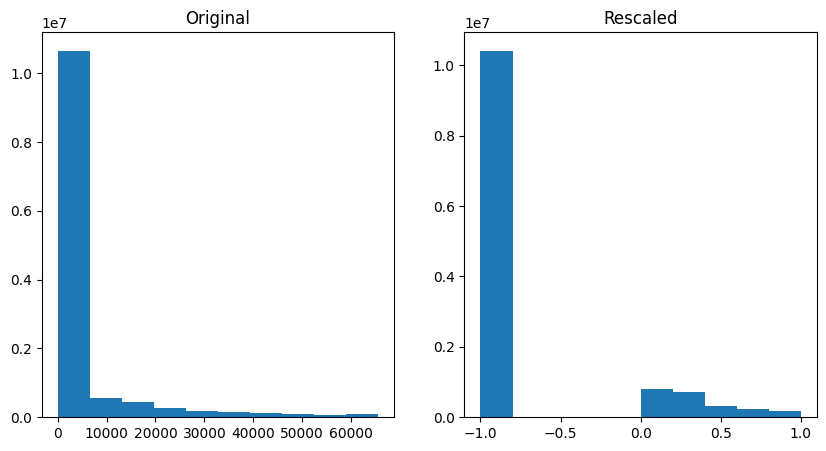

In [43]:
import matplotlib.pyplot as plt

fig, (ax, ax1) = plt.subplots(1,2, figsize = (10,5))
channel_data = img_data[1]
ax.hist(channel_data.flatten())
ax.set_title('Original')

img_data = rescale_image(img_data, full_img.channel_names)
channel_data_rescaled = img_data[1]
ax1.hist(channel_data_rescaled.flatten())
ax1.set_title('Rescaled')

# Visualizing single cell images

Normalized 3D images can be viewed using the 3D Volume Viewer **nbvv**, a multichannel viewer for interactively examining volume data.

We display our image with the volshow command. volshow accepts either a 3d or 4d data array. If the array is 4D, it will be treated as multi-channel. We can also tell volshow the physical spacing between the volume pixels in X, Y and Z dimensions (spacing). In our case the data has already been re-scaled to have equal-sized x, y, and z pixels so we just pass in [1,1,1] (the defaults) as an example. We also provide the names of the channels (channel_names) for display. 

Here are some of the main features you will use in the user interface:

- 3D / XY / XZ / YZ Click these buttons to switch between full 3D view and side projections.

- In the side projection modes, you will see one cross-sectional "slice" through the volume at a time.

- You can change the sections you are viewing using the "Clipping" tab at the bottom of the viewport.

- For multi-channel (4D CZYX) data, you can switch displayed channels on and off by clicking the volume checkbox next to each channel. You can also change the colors for each channel by clicking a swatch to the left. Note that the left panel is scrolling, and if you have many channels you may need to scroll. You can do contrast adjustment using the Settings (gear wheel) button for each channel.

In [44]:
nbvv.volshow(
    img_data,
    spacing=[1,1,1],#full_img.physical_pixel_sizes,
    channel_names=full_img.channel_names
)

VolumeWidget(dimensions={'tile_width': 204, 'tile_height': 136, 'rows': 15, 'cols': 10, 'atlas_width': 2040, '…

Image projections can be viewed either by manually projecting along an axis of a single channel,

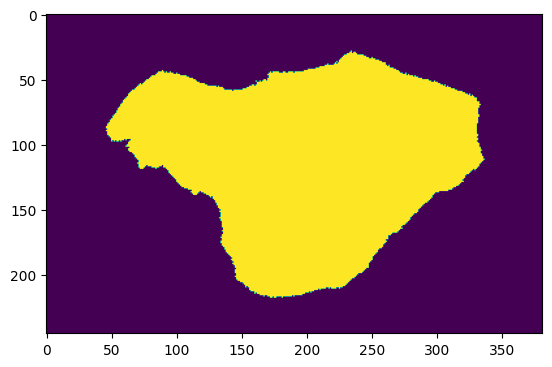

In [45]:
# Z projection of the membrane segmentation channel
plt.imshow(img_data[5].max(axis=0))
plt.show()

or by loading one of the 2D projections that have been precomputed and saved

In [46]:
projections = [
    'max_projection_x',
    'max_projection_y',
    'max_projection_z',
    'mean_projection_x',
    'mean_projection_y',
    'mean_projection_z',
    'median_projection_x',
    'median_projection_y',
    'median_projection_z',
    'center_slice'
]

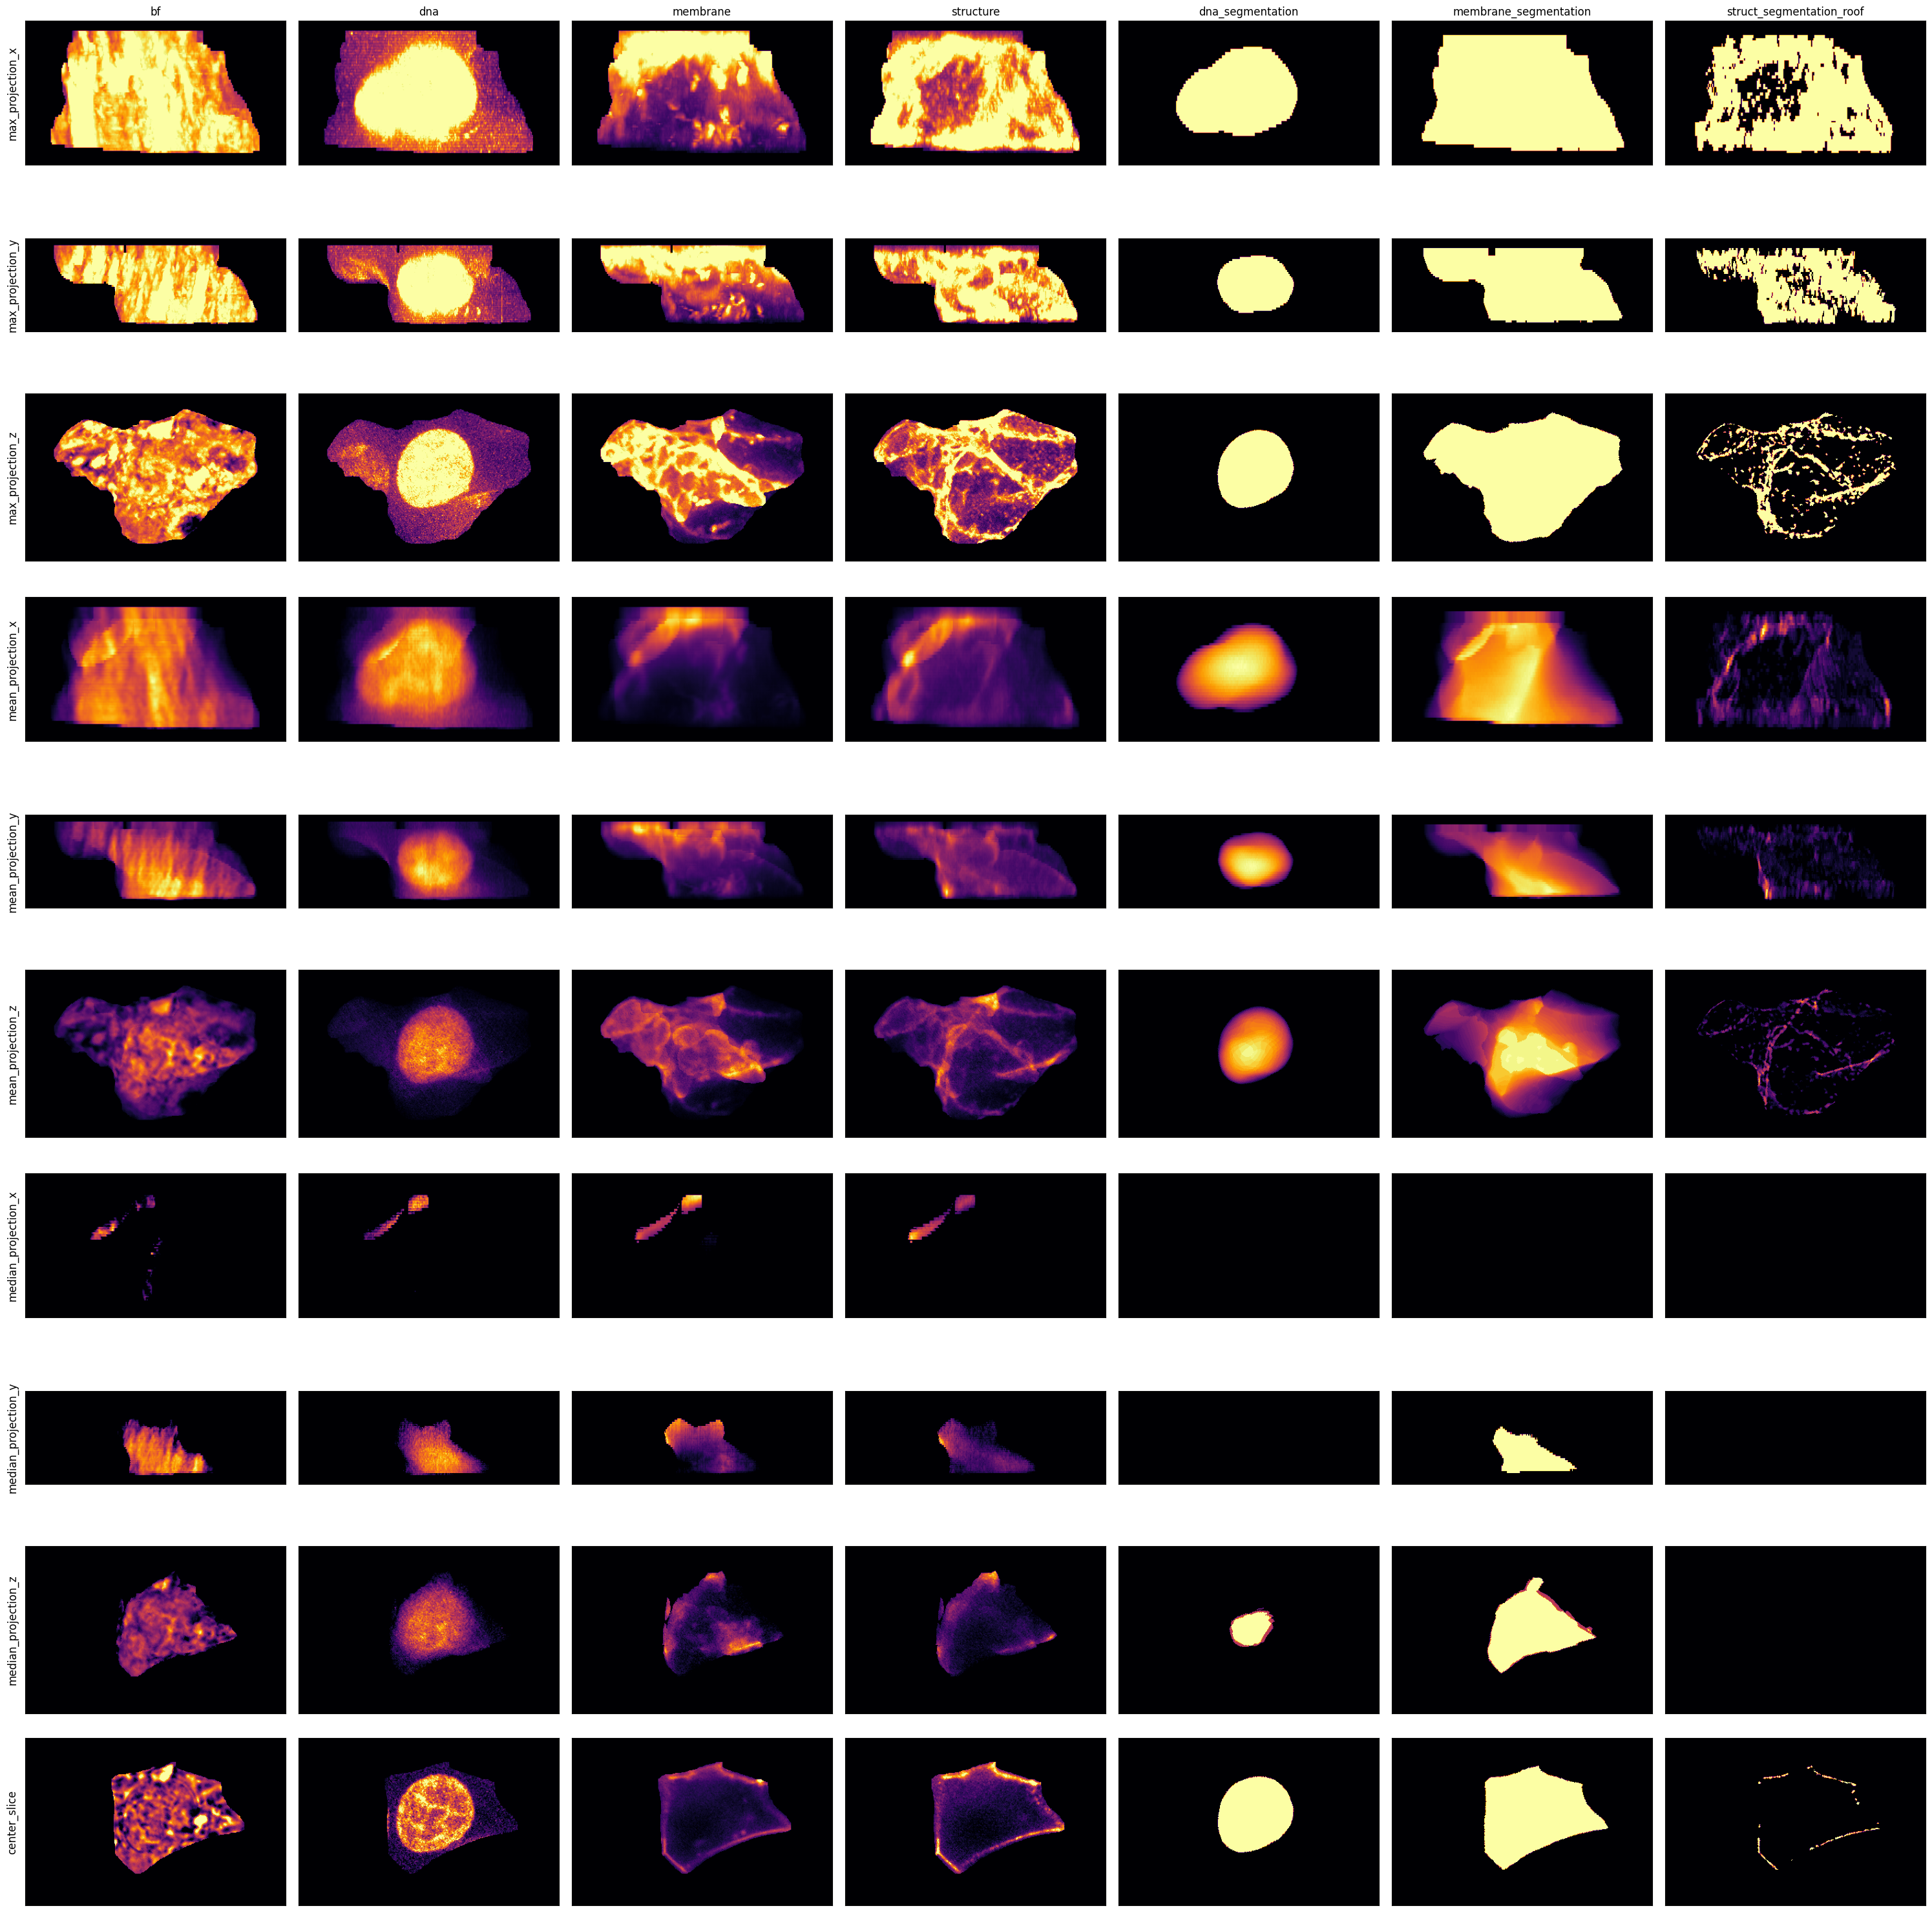

In [47]:
%matplotlib inline
f, axs = plt.subplots(len(projections), 7, figsize=(30, 30))
for proj_ix, projection in enumerate(projections):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        proj = AICSImage(some_cell[projection]).data.squeeze()
    
    for ix, channel in enumerate(full_img.channel_names):
        axs[proj_ix, ix].imshow(proj[ix], cmap="inferno")
        
        if proj_ix == 0:
            axs[proj_ix, ix].set_title(channel, size="large")
        axs[proj_ix, ix].set_xticks([])
        axs[proj_ix, ix].set_yticks([])


    axs[proj_ix, 0].set_ylabel(projection, rotation=90, size='large')

plt.tight_layout()
plt.show()

In [243]:
from viz_utils import diagnostic_sheet
diagnostic_sheet(df, max_cells=2)

In [7]:
img = AICSImage(df['max_projection_x'].iloc[0])

/opt/conda/envs/cytodata2/lib/python3.9/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


In [25]:
img_list = [img_data[i] for i in range(img_data.shape[0])]

In [41]:
            all_proj = proc.imgtoprojection(
                img_list,
                proj_all=True,
                proj_method="max",
                local_adjust=False,
                global_adjust=True,
                colors=[[1,0,0], [0,0,1]],
            )

In [42]:
all_proj.shape

(3, 137, 246)

In [43]:
all_proj = transforms.transpose_to_dims(all_proj, "CYX", "YXC")

In [44]:
all_proj = all_proj.astype(np.uint8)

In [45]:
all_proj.shape

(137, 246, 3)

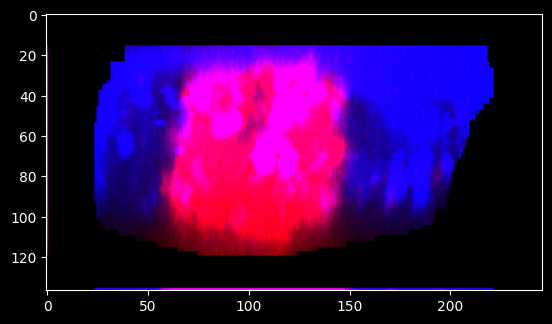

In [46]:
%matplotlib inline
plt.imshow(all_proj)

# All axis projection

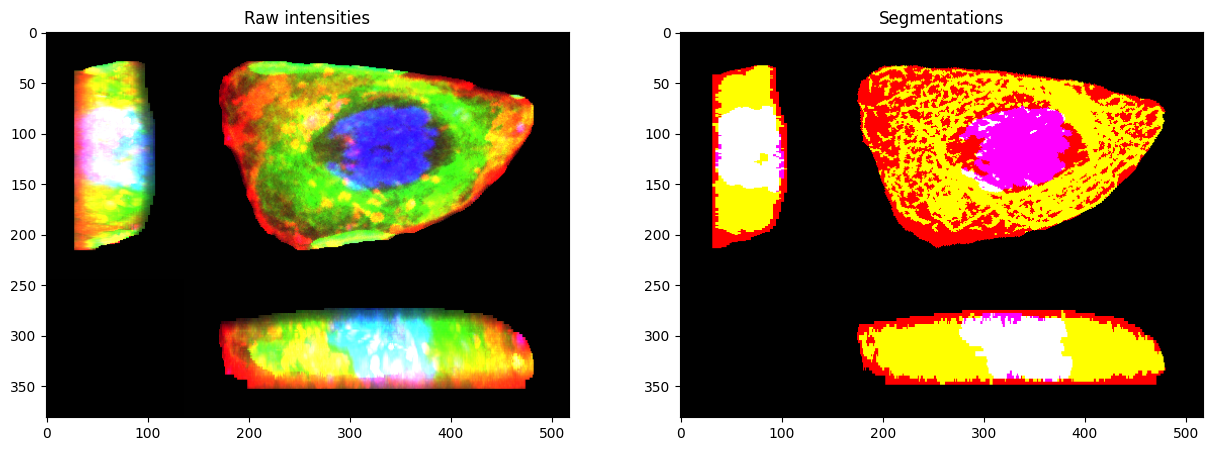

In [237]:
import aicsimageprocessing as proc
from aicsimageio import transforms

df_mito = df.loc[df['cell_stage'].isin(['M6M7_complete'])]
some_cell = df_mito.loc[df_mito['structure_name'] == 'LMNB1'].sample(1).iloc[0]
full_img = read_ome_zarr(some_cell["registered_path"])

# This will set:
# DNA to Blue
# Membrane to Red
# Structure to Green
colors = [[0, 0, 1], [1, 0, 0], [0,1,0]]

channels = {'Raw intensities': [1,2,3], 'Segmentations': [4,5,6]}
fig, axes = plt.subplots(1,2,figsize = (15, 5))

for ind, (key, chan) in enumerate(channels.items()):
    img_data = full_img.get_image_data("CZYX", C=chan)
    chan_names = [full_img.channel_names[i] for i in chan] 
    img_data = rescale_image(img_data, chan_names)
    # Get all axes projection image
    all_proj = proc.imgtoprojection(
        img_data,
        proj_all=True,
        proj_method="max",
        local_adjust=False,
        global_adjust=True,
        colors=colors,
    )
    
    # Convert to YXC for PNG writing
    all_proj = transforms.transpose_to_dims(all_proj, "CYX", "YXC")

    # Drop size to uint8
    all_proj = all_proj.astype(np.uint8)
    axes[ind].imshow(all_proj)
    axes[ind].set_title(key)

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

In [155]:
img_data_raw = img_data[1:4, ...]
img_data_seg = img_data[4:6, ...]

In [156]:
img_data_seg.shape

(2, 136, 245, 381)

In [173]:
# Get all axes projection image
all_proj = proc.imgtoprojection(
    img_data_raw,
    proj_all=True,
    proj_method="max",
    local_adjust=False,
    global_adjust=True,
    colors=colors,
)




In [174]:
all_proj.shape

(381, 517, 3)

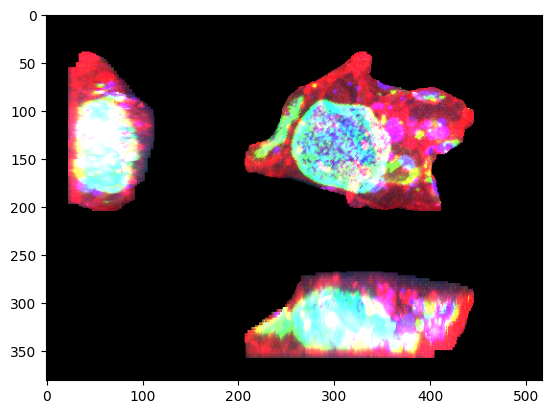

In [88]:
np.unique(all_proj[...,2])

array([  0., 255.])